In [1]:
import argparse
import sys

import tensorflow as tf
import skimage.io as io
%matplotlib inline

slim = tf.contrib.slim
Dataset = slim.python.slim.data.dataset.Dataset
DataProvider = slim.python.slim.data.data_provider.DataProvider

FLAGS = None

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

In [2]:
def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'depth': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        })
    
    # Convert from a scalar string tensor
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    height = tf.cast(features['height'], tf.int32)
    width =  tf.cast(features['width'], tf.int32)
    depth = tf.cast(features['depth'], tf.int32)
    label = tf.cast(features['label'], tf.int32)
    
    image_shape = tf.stack([height, width, depth])
    image = tf.reshape(image, image_shape)
    
    if depth == 1:
        image = tf.tile(image, [1, 1, 3])
    image = tf.reshape(image, [height, width, 3])
    image_resized = tf.image.resize_images(images=image, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    image_resized = tf.cast(image_resized, tf.uint8)
    
    images, labels = tf.train.shuffle_batch([image_resized, label],
                                           batch_size=3,
                                           capacity=30,
                                           num_threads=4,
                                           min_after_dequeue=10)
    
    return images, labels    

In [3]:
def main(_):
    tfrecords_filename = FLAGS.record
    filename_queue = tf.train.string_input_producer([tfrecords_filename], num_epochs=10)
    
    # Even when reading in multiple threads, share the filename queue
    image, label = read_and_decode(filename_queue)
    
    init_op = tf.group(tf.global_variables_initializer(),
                      tf.local_variables_initializer())
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    
    with tf.Session(config=config) as sess:
        
        sess.run(init_op)
        
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        # Let's read off 3 batches just for example
        for i in range(4):
            img, lb = sess.run([image, label])
            
            print('%d epoch' % i)
            print('label: ', lb[0])
            io.imshow(img[0])
            io.show()
            
            print('label: ', lb[1])
            io.imshow(img[1])
            io.show()
            
            print('label: ', lb[2])
            io.imshow(img[2])
            io.show()
                        
        coord.request_stop()
        coord.join(threads)
        

0 epoch
label:  41


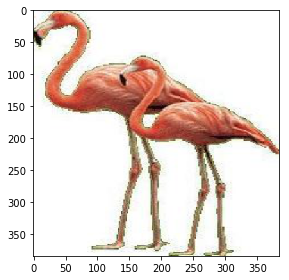

label:  17


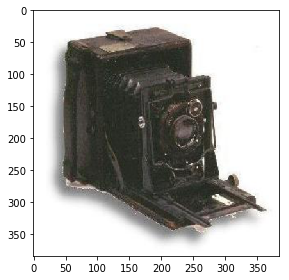

label:  95


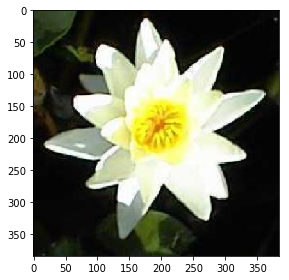

1 epoch
label:  23


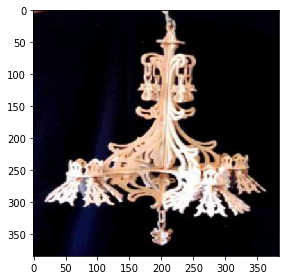

label:  13


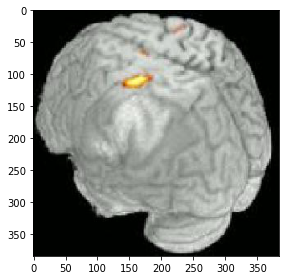

label:  1


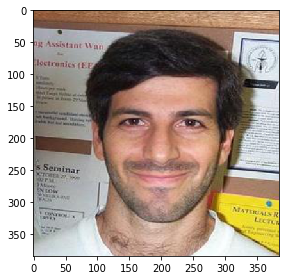

2 epoch
label:  1


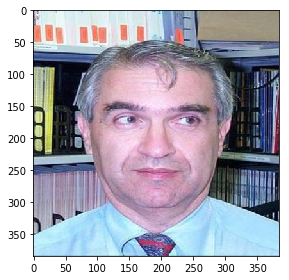

label:  3


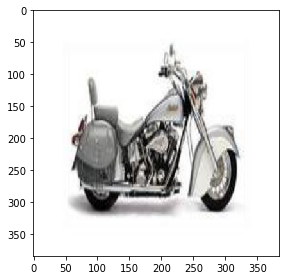

label:  85


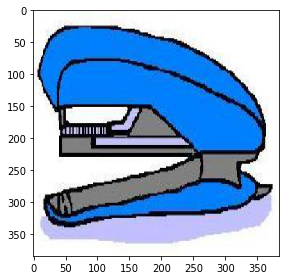

3 epoch
label:  13


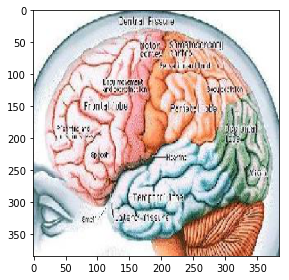

label:  1


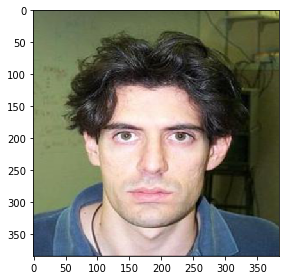

label:  3


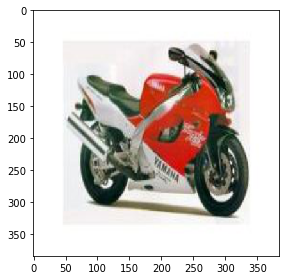

SystemExit: 

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--record',
        type=str,
        default='tmp/data/custom_train.tfrecords'
    )
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)